In [1]:
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate, integrate,optimize
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, turn_physical_off, MiyamotoNagaiPotential, plotDensities,evaluateDensities,SpiralArmsPotential
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util
import SCFbar_util_new
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
from galpy.potential import DehnenSmoothWrapperPotential as DehnenWrap


ro=8.
vo=220.

def galcencyl_to_lbd(R,phi,Z,degree=True):
    xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
    lbd=bovy_coords.XYZ_to_lbd(xyz[0],xyz[1],xyz[2],degree=degree)
    return lbd[0], lbd[1], lbd[2]

Populating the interactive namespace from numpy and matplotlib


In [6]:
Ac,As=SCFbar_util_new.compute_Acos_Asin()

Mbar=10**10.


barpot,nobarpot=SCFbar_util_new.MWPotentialSCFbar_grow(Mbar,Acos=Ac,Asin=As,pat_speed=39.,fin_phi_deg=27.,t_on=-5.,tgrow=2,tstream=10.)

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)

/home/nil/anacon

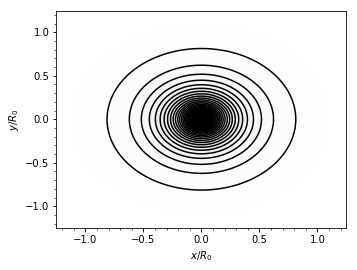

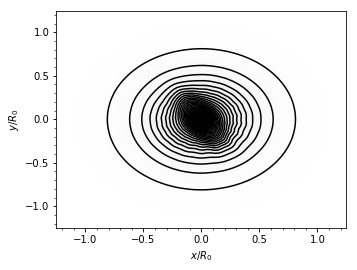

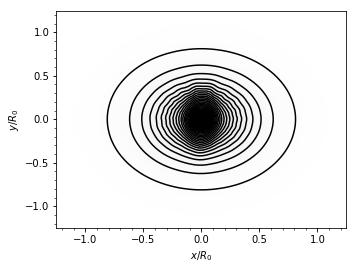

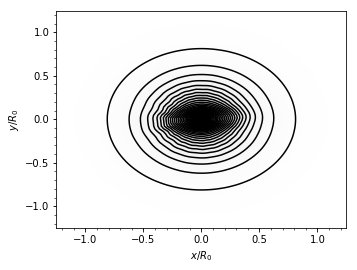

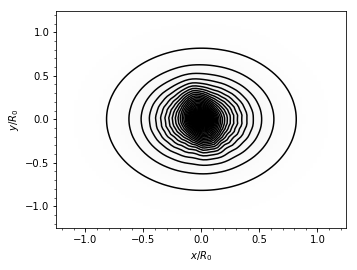

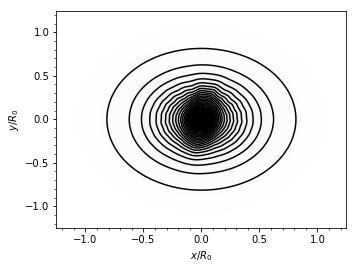

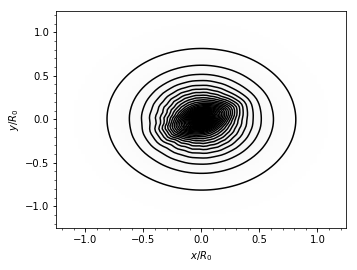

In [7]:
plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,nrs=80,nzs=80,ncontours=100,xy=True,t=-6.*u.Gyr)
plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,nrs=80,nzs=80,ncontours=100,xy=True,t=-5.*u.Gyr)
plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,nrs=80,nzs=80,ncontours=100,xy=True,t=-2.1*u.Gyr)
plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,nrs=80,nzs=80,ncontours=100,xy=True,t=-1.9*u.Gyr)
plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,nrs=80,nzs=80,ncontours=100,xy=True,t=-1.7*u.Gyr)
plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,nrs=80,nzs=80,ncontours=100,xy=True,t=-1.*u.Gyr)
plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,nrs=80,nzs=80,ncontours=100,xy=True,t=0.*u.Gyr)


### Let's start by sampling from the bulge which is modeled by PowerSphericalPotentialwCutoff(normalize=0.05,alpha=1.8,rc=1.9/8.) . 

#### https://galpy.readthedocs.io/en/latest/reference/potentialpowerspherwcut.html

#### To be modified later to take into account the time dependence of the density.

In [8]:
def rho_bulge(r,r1=8.,alpha=1.8,rc=1.9,Mbulge=0.5*10**10.):
    
    def integrand(r):
        return 4.*np.pi*(r**2.)*(r1/r)**(alpha) * np.exp(-(r/rc)**2.)
    
    norm=Mbulge/(integrate.quad(integrand,0.,np.inf)[0])
         
    return (norm)*(r1/r)**(alpha) * np.exp(-(r/rc)**2.)


/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  



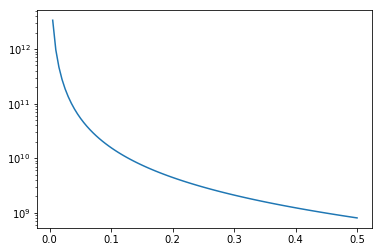

In [9]:
rr=np.linspace(0.,0.5,100)
rhob=[rho_bulge(rr[ii]) for ii in range(len(rr))]
plt.figure()
plt.semilogy(rr,rhob)
plt.show()

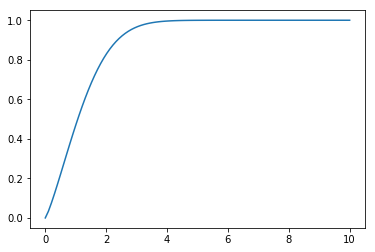

In [10]:
def cdf_bulge(r):
    def integrand(x):
        return 4.*np.pi*(x**2.)*rho_bulge(x)
    
    norm = integrate.quad(integrand,0.,np.inf)[0]
    out=integrate.quad(integrand,0.,r)[0]
    
    return out/norm

rr=np.linspace(0.001,10.,100)
cdfrho=[cdf_bulge(rr[ii]) for ii in range(len(rr))]
plt.figure()
plt.plot(rr,cdfrho)
plt.show()
  

In [33]:
def spherical_to_cylindrical(r,theta,phi):
    R = r*np.sin(phi)
    z = r*np.cos(phi)
         
    return (R,z,theta)

R,z,theta=spherical_to_cylindrical(rr1,rand_theta,rand_phi)

print (R)

[5.58803880e-01 1.59577195e+00 8.67065542e-01 2.15253755e+00
 1.33263302e+00 1.58877644e-02 6.03533308e-01 1.28571384e+00
 1.31176307e-01 4.34352021e-01 1.27064087e-01 2.47591236e+00
 2.33305773e-01 3.04618385e-01 1.93561865e-01 2.36543798e+00
 1.58280665e-01 5.96914758e-01 5.68578040e-01 1.71671355e+00
 5.57625372e-02 1.74716676e+00 6.91843281e-01 1.60048168e+00
 6.86813093e-02 2.53257239e+00 8.92998471e-03 1.97435108e-01
 2.12060742e+00 1.92596888e+00 1.28700894e+00 1.01157976e-01
 8.49341902e-01 5.28810172e-01 1.59290472e+00 1.07408411e+00
 6.21373447e-02 1.63888503e+00 1.79626341e-01 1.16525257e+00
 1.05330504e+00 1.20351394e+00 2.27089475e+00 1.12683186e+00
 2.91922631e+00 1.01893391e+00 2.23312413e+00 7.36189844e-01
 1.27474290e+00 1.58392097e+00 9.12715048e-01 1.01542155e+00
 1.73872937e+00 1.40644758e+00 8.91898635e-01 4.45533848e-01
 6.78226598e-01 1.61844170e+00 7.73635411e-02 1.10120434e+00
 1.68830866e-01 2.40740666e-01 7.62390696e-01 1.80800578e+00
 1.36340314e+00 1.284711

In [24]:

def lbd_to_galcencyl(l,b,d,degree=True):
    xyz=bovy_coords.lbd_to_XYZ(l,b,d,degree=degree)
    Rphiz=bovy_coords.XYZ_to_galcencyl(xyz[:,0],xyz[:,1],xyz[:,2],Xsun=1.,Zsun=0.)
    
    return (Rphiz[:,0],Rphiz[:,1],Rphiz[:,2])




[ 1.11954506  0.45052228  0.73336952  0.58811835 -0.66605751  0.42321453
 -0.77933384  0.21371331  1.06102997  0.1666583  -1.47501984  0.01294552
 -0.16225848  0.60188921 -1.26846885 -0.6319551  -0.45719768  0.90487822
  0.0231151  -0.18902579  0.8978145  -0.70885298  0.29507764  0.63073709
 -0.38518594  0.4235244   0.25261034 -0.83039793  0.42548314 -0.27607007
  0.76022095  1.32173713 -0.98894676 -0.23025705 -0.45819171  0.82526172
  1.39406181 -0.49514572  1.02627686  0.93225003  0.04515159  0.1790262
 -0.32547541 -0.62222828  0.24682752 -0.18349588 -0.50852777  0.03559239
  0.42444071 -0.42241097 -0.129714   -0.39161959 -0.25033946  0.3827498
 -0.94531254 -0.16064681 -0.29150864  0.32047812 -1.53894024  0.16604792
 -1.48141375 -0.19546177  0.24187767  0.09040226 -0.86387674 -0.41194253
  0.60702236  0.80402213  0.44729385  0.59709385  0.66407333  0.40564765
 -0.74546478 -0.66949874 -0.54371672  0.23306428  0.09192717 -0.66047123
  0.56150184 -0.55876088  0.56484578  0.21220117  0.2

In [36]:
#assign circular velocity

from galpy.potential import MWPotential2014, turn_physical_off, vcirc

#print (R)

vR=np.zeros(nr)
vz=np.zeros(nr)
vT=np.empty(nr)

vT=vcirc(nobarpot,R/8.)    
print (vT)

[0.6051192  0.88601717 0.70373803 0.96962548 0.83192415 0.36769658
 0.61787225 0.82109514 0.49465752 0.57417093 0.4943993  1.00187543
 0.5188208  0.54137574 0.50646783 0.992038   0.49808748 0.61592644
 0.60782488 0.9075254  0.48534302 0.91263412 0.64545867 0.886892
 0.49144607 1.00648396 0.29622436 0.50758135 0.96584338 0.94023572
 0.82139941 0.49398443 0.69791353 0.59710311 0.88548307 0.76680368
 0.48905035 0.89391135 0.50273196 0.79136392 0.76093491 0.80112497
 0.98267064 0.78124394 1.03102635 0.75099759 0.97867096 0.66010612
 0.81850508 0.88380218 0.7184816  0.74996584 0.91123083 0.84818869
 0.71180865 0.57677036 0.64104084 0.89019992 0.49315415 0.77430895
 0.50019606 0.52125268 0.66887346 0.92248024 0.83881547 0.82085933
 0.72276444 0.71347392 0.85139911 0.5958473  0.84985833 0.84624635
 0.58318392 0.81585467 0.73079482 0.99079713 0.69801605 0.7824121
 0.58533403 0.75613815 0.49662864 1.05638714 0.84252565 0.88603862
 0.59232841 0.6139934  0.78172277 0.71728651 0.90465334 0.5273690

In [37]:
coord=[]
    
for ii in range(50):
        coord.append([R[ii]/8.,vR[ii],vT[ii],z[ii]/8.,vz[ii],rand_theta[ii]])
        
t_age=np.linspace(-6.,0.,1001)/bovy_conversion.time_in_Gyr(vo,ro)
        
orbits=[]
for ii in range(50):
    
        orbits.append(Orbit(coord[ii]))
        orbits[ii].turn_physical_off()
        orbits[ii].integrate(t_age,barpot)

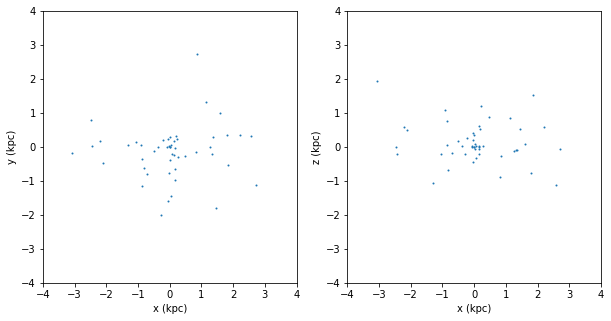

In [41]:
x1=[]
y1=[]
z1=[]

for ii in range(50):
    x1.append(orbits[ii].x(t_age[500])*8.)
    y1.append(orbits[ii].y(t_age[500])*8.)
    z1.append(orbits[ii].z(t_age[500])*8.)
    
    
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x1,y1,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)

plt.subplot(1,2,2)
plt.scatter(x1,z1,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)

plt.show()

In [ ]:
rr=np.linspace(0.001,10.,1000)
cdfrho=[cdf_bulge(rr[ii]) for ii in range(len(rr))]
icdf= interpolate.InterpolatedUnivariateSpline(cdfrho,rr,k=1)

nr=100
rr1=[]
for jj in range(nr):
    rr1.append(icdf(numpy.random.uniform()))
    
plt.figure()
plt.hist(rr1,bins=100)
plt.show()

rand_theta=np.random.uniform(0.,2.*np.pi,nr)
rand_phi=np.arccos(1.- 2.*np.random.uniform(0.,1.,nr))   

### Combine sampled points

In [44]:
tout = np.linspace(-9.,0.,10)




for kk in tout : 
        tt = round(kk,1)  
        x=[]
        y=[]
        z=[]
        vx=[]
        vy=[]
        vz=[]
        print (tt)
        for ii in range(101):
            dat=np.loadtxt('sampled_bulge_9Gyr/N10_sample_bulge_9Gyr_timestep{}Gyr_{}.dat'.format(tt,ii))
            x.append(dat[:,1])
            y.append(dat[:,2])
            z.append(dat[:,3])
            vx.append(dat[:,4])
            vy.append(dat[:,5])
            vz.append(dat[:,6])
            
        x1 = [item for sublist in x for item in sublist]
        y1 = [item for sublist in y for item in sublist]
        z1 = [item for sublist in z for item in sublist]
        vx1 = [item for sublist in vx for item in sublist]
        vy1 = [item for sublist in vy for item in sublist]
        vz1 = [item for sublist in vz for item in sublist]
        
        fo=open('sampled_bulge_9Gyr/combined/sample_bulge_9Gyr_timestep{}Gyr.dat'.format(tt),'w')
        for jj in range(len(x1)):
            fo.write(str(tt) + "  " +str(x1[jj]) + "  " + str(y1[jj]) + "  " + str(z1[jj]) + "  " + str(vx1[jj]) + "  " + str(vy1[jj]) + "  " + str(vz1[jj]) + "\n")
            
        fo.close()   


-9.0
-8.0
-7.0
-6.0
-5.0
-4.0
-3.0
-2.0
-1.0
0.0


### plot the projections of the sampled points

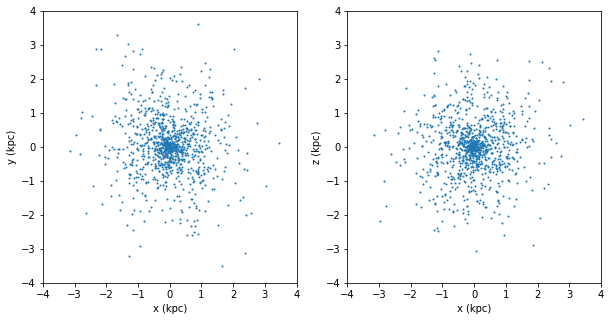

In [59]:
kk=-9.0
dat=np.loadtxt('sampled_bulge_9Gyr/combined/sample_bulge_9Gyr_timestep{}Gyr.dat'.format(kk))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dat[:,1]*8.,dat[:,2]*8.,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)

plt.subplot(1,2,2)
plt.scatter(dat[:,1]*8.,dat[:,3]*8.,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
    
plt.show()

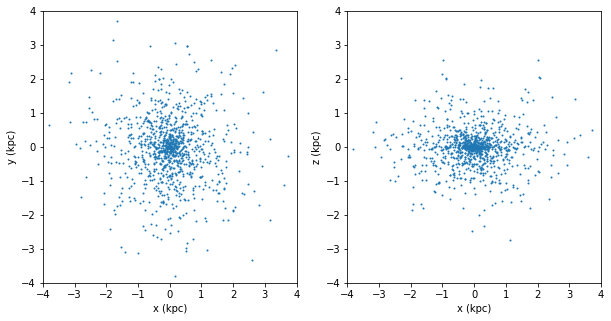

In [48]:
kk=-8.0
dat=np.loadtxt('sampled_bulge_9Gyr/combined/sample_bulge_9Gyr_timestep{}Gyr.dat'.format(kk))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dat[:,1]*8.,dat[:,2]*8.,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)

plt.subplot(1,2,2)
plt.scatter(dat[:,1]*8.,dat[:,3]*8.,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
    
plt.show()
    
    

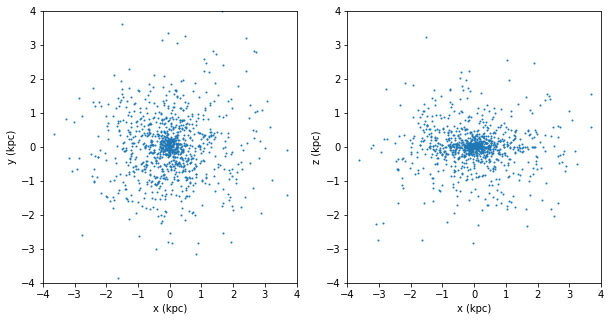

In [49]:
kk=-7.0
dat=np.loadtxt('sampled_bulge_9Gyr/combined/sample_bulge_9Gyr_timestep{}Gyr.dat'.format(kk))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dat[:,1]*8.,dat[:,2]*8.,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)

plt.subplot(1,2,2)
plt.scatter(dat[:,1]*8.,dat[:,3]*8.,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
    
plt.show()
    
    

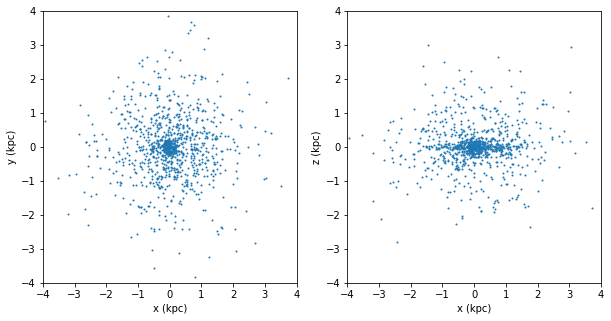

In [50]:
kk=-6.0
dat=np.loadtxt('sampled_bulge_9Gyr/combined/sample_bulge_9Gyr_timestep{}Gyr.dat'.format(kk))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dat[:,1]*8.,dat[:,2]*8.,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)

plt.subplot(1,2,2)
plt.scatter(dat[:,1]*8.,dat[:,3]*8.,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
    
plt.show()
    
    

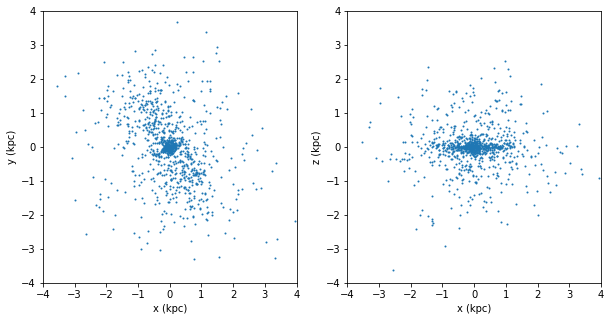

In [51]:
kk=-5.0
dat=np.loadtxt('sampled_bulge_9Gyr/combined/sample_bulge_9Gyr_timestep{}Gyr.dat'.format(kk))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dat[:,1]*8.,dat[:,2]*8.,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)

plt.subplot(1,2,2)
plt.scatter(dat[:,1]*8.,dat[:,3]*8.,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
    
plt.show()
    
    

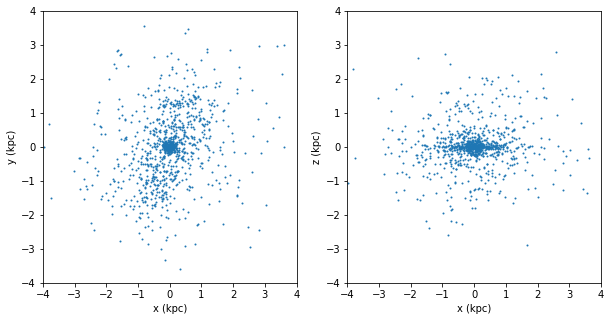

In [52]:
kk=-4.0
dat=np.loadtxt('sampled_bulge_9Gyr/combined/sample_bulge_9Gyr_timestep{}Gyr.dat'.format(kk))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dat[:,1]*8.,dat[:,2]*8.,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)

plt.subplot(1,2,2)
plt.scatter(dat[:,1]*8.,dat[:,3]*8.,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
    
plt.show()
    
    

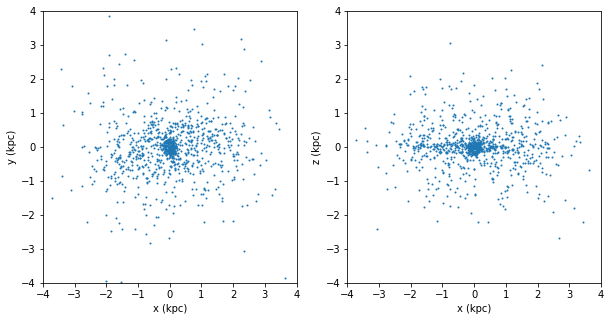

In [53]:
kk=-3.0
dat=np.loadtxt('sampled_bulge_9Gyr/combined/sample_bulge_9Gyr_timestep{}Gyr.dat'.format(kk))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dat[:,1]*8.,dat[:,2]*8.,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)

plt.subplot(1,2,2)
plt.scatter(dat[:,1]*8.,dat[:,3]*8.,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
    
plt.show()
    
    

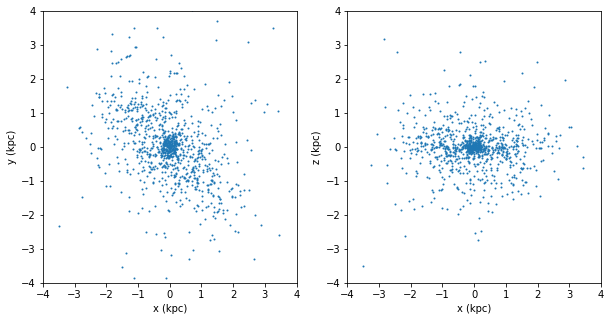

In [54]:
kk=-2.0
dat=np.loadtxt('sampled_bulge_9Gyr/combined/sample_bulge_9Gyr_timestep{}Gyr.dat'.format(kk))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dat[:,1]*8.,dat[:,2]*8.,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)

plt.subplot(1,2,2)
plt.scatter(dat[:,1]*8.,dat[:,3]*8.,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
    
plt.show()
    
    

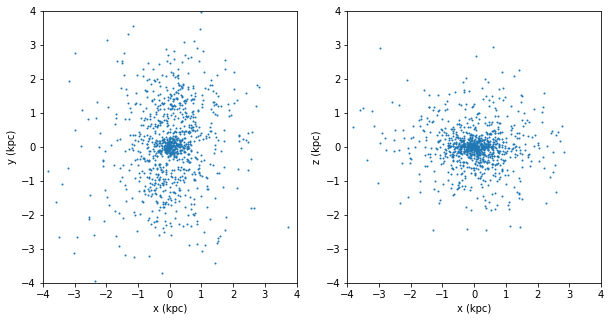

In [55]:
kk=-1.0
dat=np.loadtxt('sampled_bulge_9Gyr/combined/sample_bulge_9Gyr_timestep{}Gyr.dat'.format(kk))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dat[:,1]*8.,dat[:,2]*8.,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)

plt.subplot(1,2,2)
plt.scatter(dat[:,1]*8.,dat[:,3]*8.,s=1)
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
    
plt.show()
    
    

### First we will setup the spiral arms
Cox and Gomez : $\phi$ + $\Omega$ t - $\phi_{p}(r_{o})$ ; Monari et al : $\phi$ - $\Omega_{s}$ t - $\phi_{s}$, they took $\Omega_{s}$ $t_{e}$ + $\phi_{s} = -26^{\circ}$  
Monari's phi_s is phi_ref in galpy
Monari also doesn't have exponential decay along the radius. Cox and Gomez and galpy
have a radial exponential decay with scale length Rs=7 kpc (Cox and Gomez).

We will set the amplitude of the spiral arms following Monari : i.e., at the location of the sun the radial force due to the spiral is 0.5-1% of the radial force in the axisymmetric potential. 




In [ ]:
# This bar doesn't grow, will add the growth feature later.

def spiral_arms_potential(FR_frac=1.,cos=True,N=2,pat_speed=24.5,pitch_angle=9.9,r_ref=8.,Rs=7.,phi0=26.,H=0.3):
    
    
        phi0=np.radians(phi0)
        omega=pat_speed*(ro/vo)
        alpha=numpy.radians(pitch_angle)
        r_ref/=ro
        Rs/=ro
        H/=ro

        # percentage of the radial force to set the amplitude of the spiral
        FR_frac=FR_frac*0.01  
        
        if cos :
            Cs=[8./(3.*numpy.pi),0.5,8./(15.*numpy.pi)]
            
        else :
            Cs=[1]
            
        #compute max radial force for amp=1
        pp=np.linspace(0.,2.*np.pi,1000)
        FR_nonaxi=[]
        spiral_pot_amp1=SpiralArmsPotential(amp=1.,N=N,omega=omega,alpha=alpha,phi_ref=phi0,r_ref=r_ref,H=H,Rs=Rs,Cs=Cs)
        turn_physical_off(spiral_pot_amp1)
        
        for ii in range(len(pp)):
             FR_nonaxi.append(potential.evaluateRforces(spiral_pot_amp1,R=8./ro,z=0.,phi=pp[ii],t=0.))

        interp_FR_nonaxi= interpolate.InterpolatedUnivariateSpline(pp,FR_nonaxi)

        #fmin, because radial force is negative
        max_phi=optimize.fmin(interp_FR_nonaxi, 0.,disp=0)

        max_FR_nonaxi= interp_FR_nonaxi(max_phi)[0]
                
        #compute the radial force due to the axisymmetric potential
        FR_axi=potential.evaluateRforces(MWPotential2014,R=8./ro,z=0.,t=0.)

        #compute the correct amplitude
        amp= numpy.abs(FR_frac*FR_axi/max_FR_nonaxi)
        
        #setup spiral potential with correct amplitude
        spiralpot=SpiralArmsPotential(amp=amp,N=N,omega=omega,alpha=alpha,phi_ref=phi0,r_ref=r_ref,H=H,Rs=Rs,Cs=Cs)
        turn_physical_off(spiralpot)
        
        return spiralpot


In [ ]:
spiral_pot= spiral_arms_potential(FR_frac=1.)

pp=np.linspace(0.,2.*np.pi,1000)

FR=[]

for ii in range(len(pp)):
    FR.append(potential.evaluateRforces(spiral_pot,R=8./ro,z=0.,phi=pp[ii],t=0.))
    


plt.figure()
plt.plot(pp,FR,c='r',label=r'$1\%$')
plt.title('Radial force')
plt.legend(loc='upper right')
plt.show()

In [ ]:
omega=24.5*(ro/vo)
Tspiral=2.*np.pi/omega

print (Tspiral*bovy_conversion.time_in_Gyr(vo,ro))

In [ ]:
#plot the spiral's density contours

plotDensities(spiral_pot,rmin=-60.*u.kpc,rmax=60.*u.kpc,zmax=60.*u.kpc,zmin=-60.*u.kpc,nrs=80,nzs=80,ncontours=100,xy=True,t=-9.*u.Gyr)
plotDensities(spiral_pot,rmin=-60.*u.kpc,rmax=60.*u.kpc,zmax=60.*u.kpc,zmin=-60.*u.kpc,nrs=80,nzs=80,ncontours=100,xy=True,t=-5.*u.Gyr)
plotDensities(spiral_pot,rmin=-60.*u.kpc,rmax=60.*u.kpc,zmax=60.*u.kpc,zmin=-60.*u.kpc,nrs=80,nzs=80,ncontours=100,xy=True,t=-4.9*u.Gyr)
plotDensities(spiral_pot,rmin=-60.*u.kpc,rmax=60.*u.kpc,zmax=60.*u.kpc,zmin=-60.*u.kpc,nrs=80,nzs=80,ncontours=100,xy=True,t=-4.8*u.Gyr)
plotDensities(spiral_pot,rmin=-60.*u.kpc,rmax=60.*u.kpc,zmax=60.*u.kpc,zmin=-60.*u.kpc,nrs=80,nzs=80,ncontours=100,xy=True,t=-4.7*u.Gyr)
plotDensities(spiral_pot,rmin=-60.*u.kpc,rmax=60.*u.kpc,zmax=60.*u.kpc,zmin=-60.*u.kpc,nrs=80,nzs=80,ncontours=100,xy=True,t=0.*u.Gyr)


In [ ]:
barpot1=barpot + [spiral_pot]